In [1]:
# Import relevant packages
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
dr_data = pd.read_csv('dr_frequent_articles.csv', sep = ',')

# convert data to a list
article_text = dr_data['Text lemmatized'].values

In [3]:
# convert all articles into lists
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(article_text))

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# The LDA - model

## Step 1: Determine number of Categories to include in the model
Testing optimal number of categories. 
Takes longer to run, hence we have commented out the code in step 1 below for the sake of you running the code. 

In [5]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [6]:
# Compute different models where the only change is number of categories
# Print coherence value for each model, i.e. number of categories
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [7]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=4, limit=20, step=1)

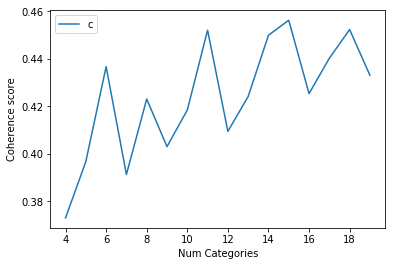

In [8]:
# Create graph showing the coherence value for number of topics
limit=20; start=4; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Categories")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [9]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 4  has Coherence Value of 0.3731
Num Topics = 5  has Coherence Value of 0.3968
Num Topics = 6  has Coherence Value of 0.4368
Num Topics = 7  has Coherence Value of 0.3914
Num Topics = 8  has Coherence Value of 0.4231
Num Topics = 9  has Coherence Value of 0.4031
Num Topics = 10  has Coherence Value of 0.4185
Num Topics = 11  has Coherence Value of 0.4521
Num Topics = 12  has Coherence Value of 0.4095
Num Topics = 13  has Coherence Value of 0.4242
Num Topics = 14  has Coherence Value of 0.45
Num Topics = 15  has Coherence Value of 0.4563
Num Topics = 16  has Coherence Value of 0.4254
Num Topics = 17  has Coherence Value of 0.4403
Num Topics = 18  has Coherence Value of 0.4524
Num Topics = 19  has Coherence Value of 0.4331


From the coherence scores and graph above, combined with several manual changes to the settings of the random_state, update_every, chunksize, passes and alpha we decided on a model to go with for the rest of the analysis.

# The LDA-model

In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"flygtning" + 0.016*"barn" + 0.011*"ar" + 0.008*"politi" + '
  '0.008*"syrien" + 0.008*"familie" + 0.007*"land" + 0.007*"menneske" + '
  '0.006*"bo" + 0.006*"ifølge"'),
 (1,
  '0.027*"indvandrer" + 0.013*"dansk" + 0.010*"procent" + 0.009*"dansker" + '
  '0.009*"ar" + 0.008*"ga" + 0.008*"arbejde" + 0.007*"vestlig" + '
  '0.006*"efterkommer" + 0.006*"tale"'),
 (2,
  '0.052*"tyskland" + 0.049*"tysk" + 0.035*"merkel" + 0.023*"norge" + '
  '0.016*"angela" + 0.015*"norsk" + 0.013*"nsu" + 0.011*"kansler" + '
  '0.010*"parti" + 0.009*"afd"'),
 (3,
  '0.043*"eu" + 0.025*"land" + 0.022*"europa" + 0.010*"flygtning" + '
  '0.009*"kæmpe" + 0.008*"bad" + 0.007*"europæisk" + 0.007*"tyrkiet" + '
  '0.006*"grænse" + 0.006*"myanmar"'),
 (4,
  '0.025*"danmark" + 0.018*"dansk" + 0.015*"regering" + 0.015*"flygtning" + '
  '0.012*"kommune" + 0.011*"ar" + 0.009*"land" + 0.007*"mene" + '
  '0.006*"venstre" + 0.006*"folkeparti"'),
 (5,
  '0.021*"usa" + 0.016*"præsident" + 0.014*"amerikansk" + 0.0

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.200951051665202

Coherence Score:  0.4367610133544196


In [17]:
# Determine the dominant topic for each article
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.4650,"usa, præsident, amerikansk, trumpe, land, obama, muslimsk, skrive, donald, verden","[mexicansk, hær, befri, migrant, holde, fange, gruppe, kriminel, nordlig, mexico, offer, central..."
1,1,3.0,0.5784,"eu, land, europa, flygtning, kæmpe, bad, europæisk, tyrkiet, grænse, myanmar","[italiensk, kystvagt, udrette, torsdag, heltepræstation, redde, afrikansk, migrant, migrant, stu..."
2,2,0.0,0.6219,"flygtning, barn, ar, politi, syrien, familie, land, menneske, bo, ifølge","[politi, københavn, lufthavn, lade, illegal, migrant, slippe, kontrol, sagtens, stoppe, lyde, pa..."
3,3,3.0,0.6614,"eu, land, europa, flygtning, kæmpe, bad, europæisk, tyrkiet, grænse, myanmar","[antal, dø, afrikansk, asylsøger, italiensk, lampedusa, belyse, europa, problem, handtere, flygt..."
4,4,3.0,0.4550,"eu, land, europa, flygtning, kæmpe, bad, europæisk, tyrkiet, grænse, myanmar","[hab, fremtid, dødelig, udgang, person, sidste, ar, omkomme, forsøg, afrika, europa, rekordmange..."
5,5,3.0,0.4312,"eu, land, europa, flygtning, kæmpe, bad, europæisk, tyrkiet, grænse, myanmar","[time, flyde, rund, dø, krop, fortælle, arig, germani, nagassi, glemme, opleve, torsdag, morgen,..."
6,6,3.0,0.7946,"eu, land, europa, flygtning, kæmpe, bad, europæisk, tyrkiet, grænse, myanmar","[malta, premierminister, joseph, muscat, europæisk, farvand, tæt, afrika, kirkegard, overfylde, ..."
7,7,3.0,0.7791,"eu, land, europa, flygtning, kæmpe, bad, europæisk, tyrkiet, grænse, myanmar","[sen, badkæntning, flygtning, italien, kyse, italien, bede, eu, hjælp, handtere, kraftig, strøm,..."
8,8,3.0,0.6986,"eu, land, europa, flygtning, kæmpe, bad, europæisk, tyrkiet, grænse, myanmar","[dødstal, voks, fiskerbad, asylansøger, kur, australien, forlise, nat, onsdag, dansk, tid, indon..."
9,9,1.0,0.5222,"indvandrer, dansk, procent, dansker, ar, ga, arbejde, vestlig, efterkommer, tale","[kina, premierminister, wen, jibao, opfordre, land, virksomhed, behandle, ung, ansat, forlade, h..."


## Creating the area chart showing change of occurance of article topics over time

In [24]:
# Join the dominant topics back to the original dataset
dr_data_topic = pd.concat([dr_data, df_dominant_topic], sort=True, axis=1)

# Groupby date and dominant topic to count number of articles within each date and topic
topic_date = dr_data_topic.groupby(['Publish date', 'Dominant_Topic']).count()

In [35]:
# Add a quarter varibel to roll-up data to a quarterly level
dr_data_topic['Date Quarter'] = pd.to_datetime(dr_data_topic['Publish date']).dt.to_period('Q')
topics_day = dr_data_topic.groupby(['Date Quarter', 'Dominant_Topic'])['Document_No'].count().reset_index()

# Pivot data for to get dominant topics as column names
topics = topics_day.pivot_table('Document_No', 'Date Quarter', 'Dominant_Topic')


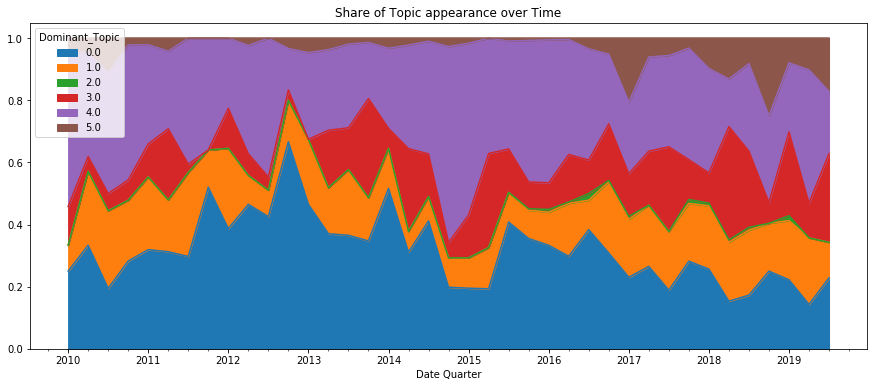

In [36]:
# Normalize the data to get share of total
normalizedDataFrame = topics.divide(topics.sum(axis=1), axis=0);

import matplotlib.pyplot as plot

# Draw a percentage based, stacked area plot
normalizedDataFrame.plot.area(stacked=True, figsize=(15,6), title=('Share of Topic appearance over Time'));

plot.show(block=True);

# Descriptive data of the different topics

In [15]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9509,"flygtning, barn, ar, politi, syrien, familie, ...","[adskillig, gang, løb, sen, maned, oprette, as..."
1,1.0,0.8326,"indvandrer, dansk, procent, dansker, ar, ga, a...","[stemmeprocent, steg, ar, kommunalvalg, omrade..."
2,2.0,0.4071,"tyskland, tysk, merkel, norge, angela, norsk, ...","[forbundskansler, angela, merkel, konservativ,..."
3,3.0,0.8563,"eu, land, europa, flygtning, kæmpe, bad, europ...","[torsdag, italiensk, kystvagtsskib, diciotti, ..."
4,4.0,0.9218,"danmark, dansk, regering, flygtning, kommune, ...","[stramning, asylregel, regering, sid, sla, sta..."
5,5.0,0.6991,"usa, præsident, amerikansk, trumpe, land, obam...","[amerikansk, præsident, ofte, dømme, første, d..."


# Create wordclouds for each topic
To get an idea of the most common word within each topic we start by creating 6 wordclouds.

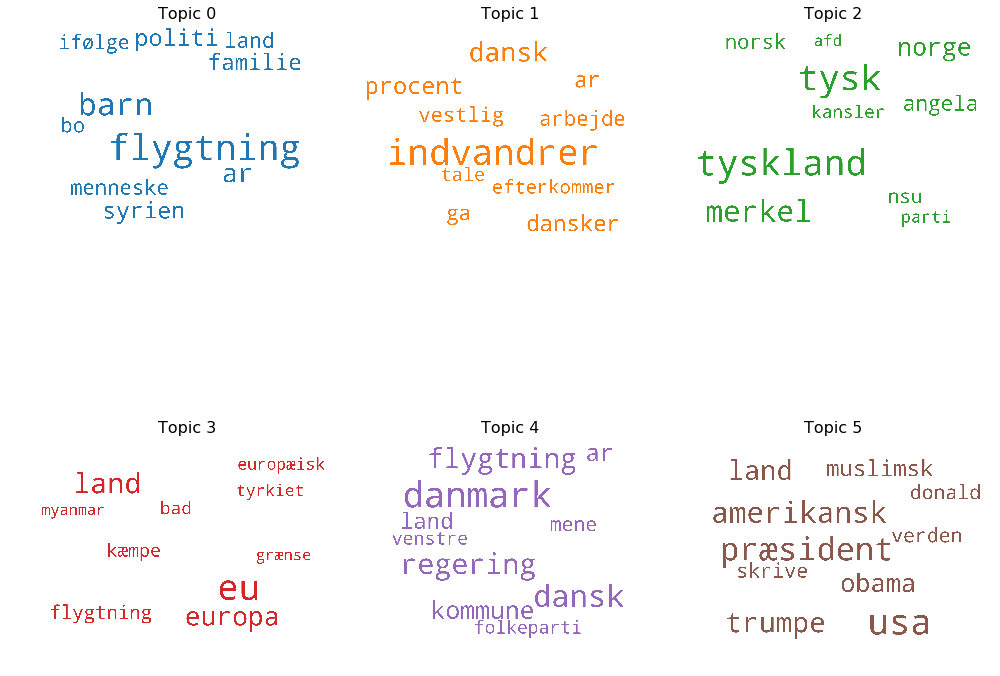

In [38]:
# Wordclouds of Top 10 words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(14,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Create graphs showing word counts and weights of keywords within each topic
To make a better determination of what each category contains of, we have looked at the number of times the key words appears and the weights and thereby manually agreed upon some fitting topic names:

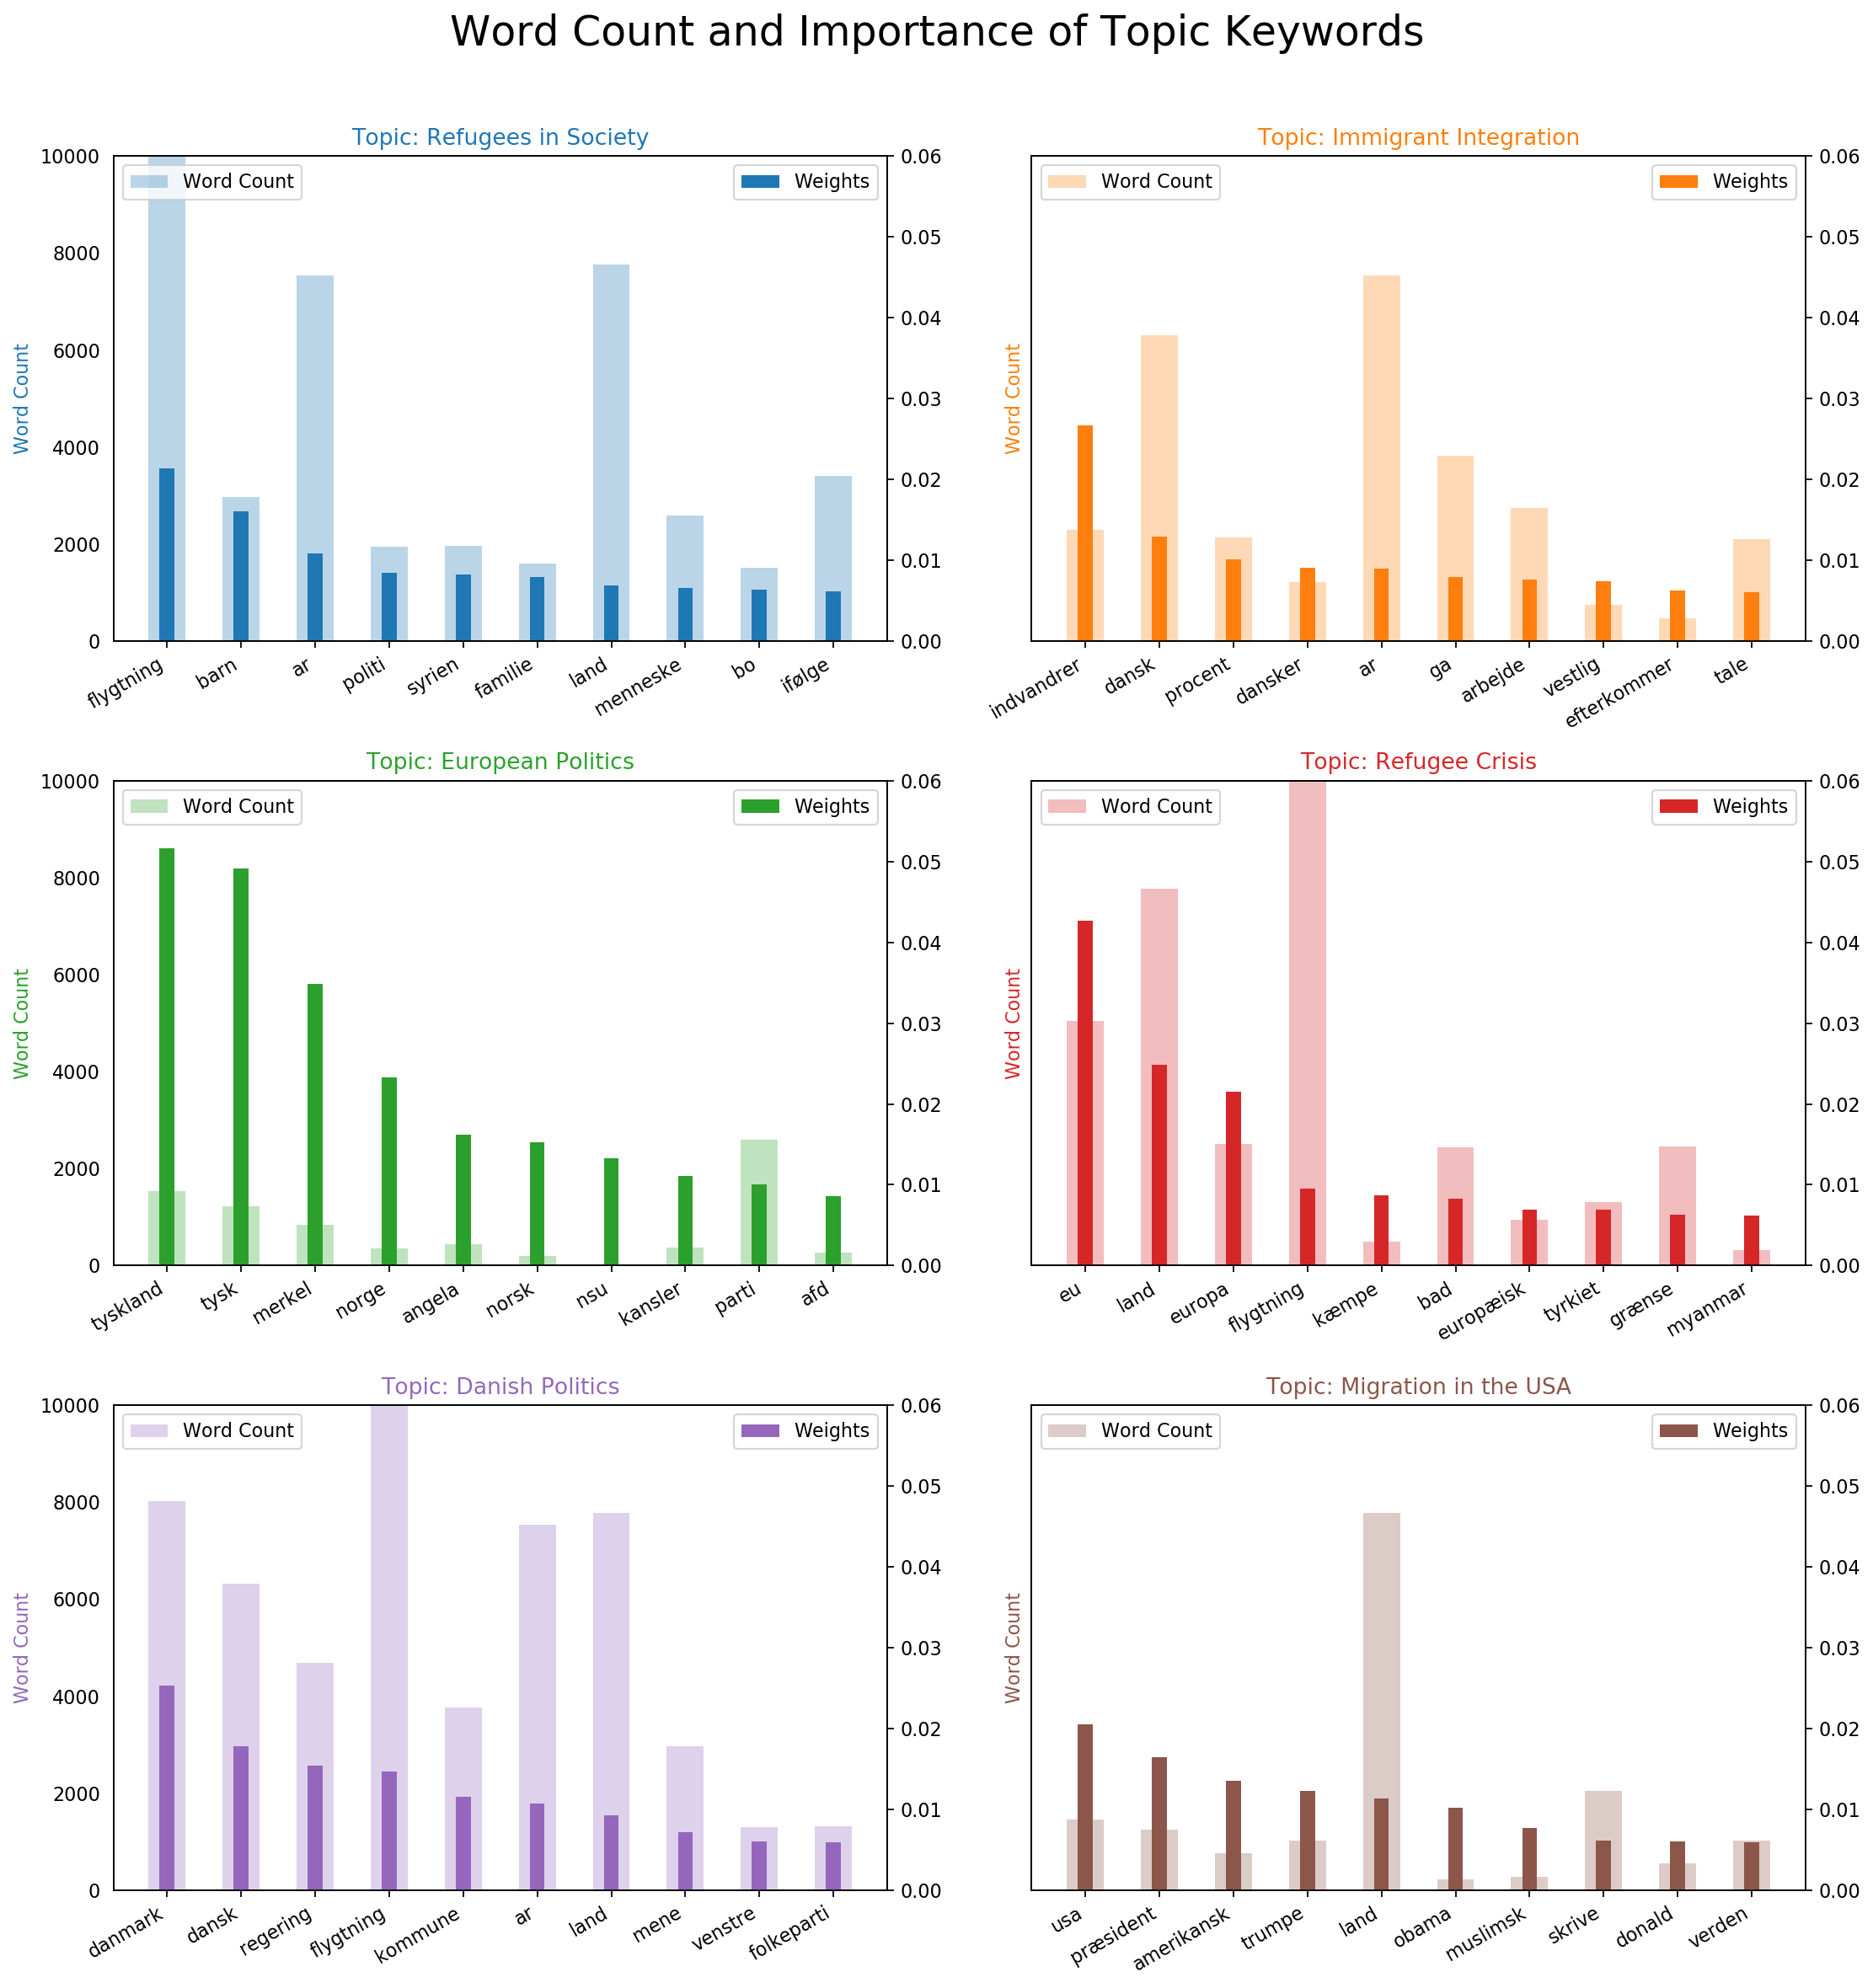

In [39]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

topic_names = ['Refugees in Society', 'Immigrant Integration', 'European Politics', 'Refugee Crisis', 'Danish Politics', 'Migration in the USA']

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,14), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.06); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(topic_names[i]), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Distribution of Word Counts in Documents

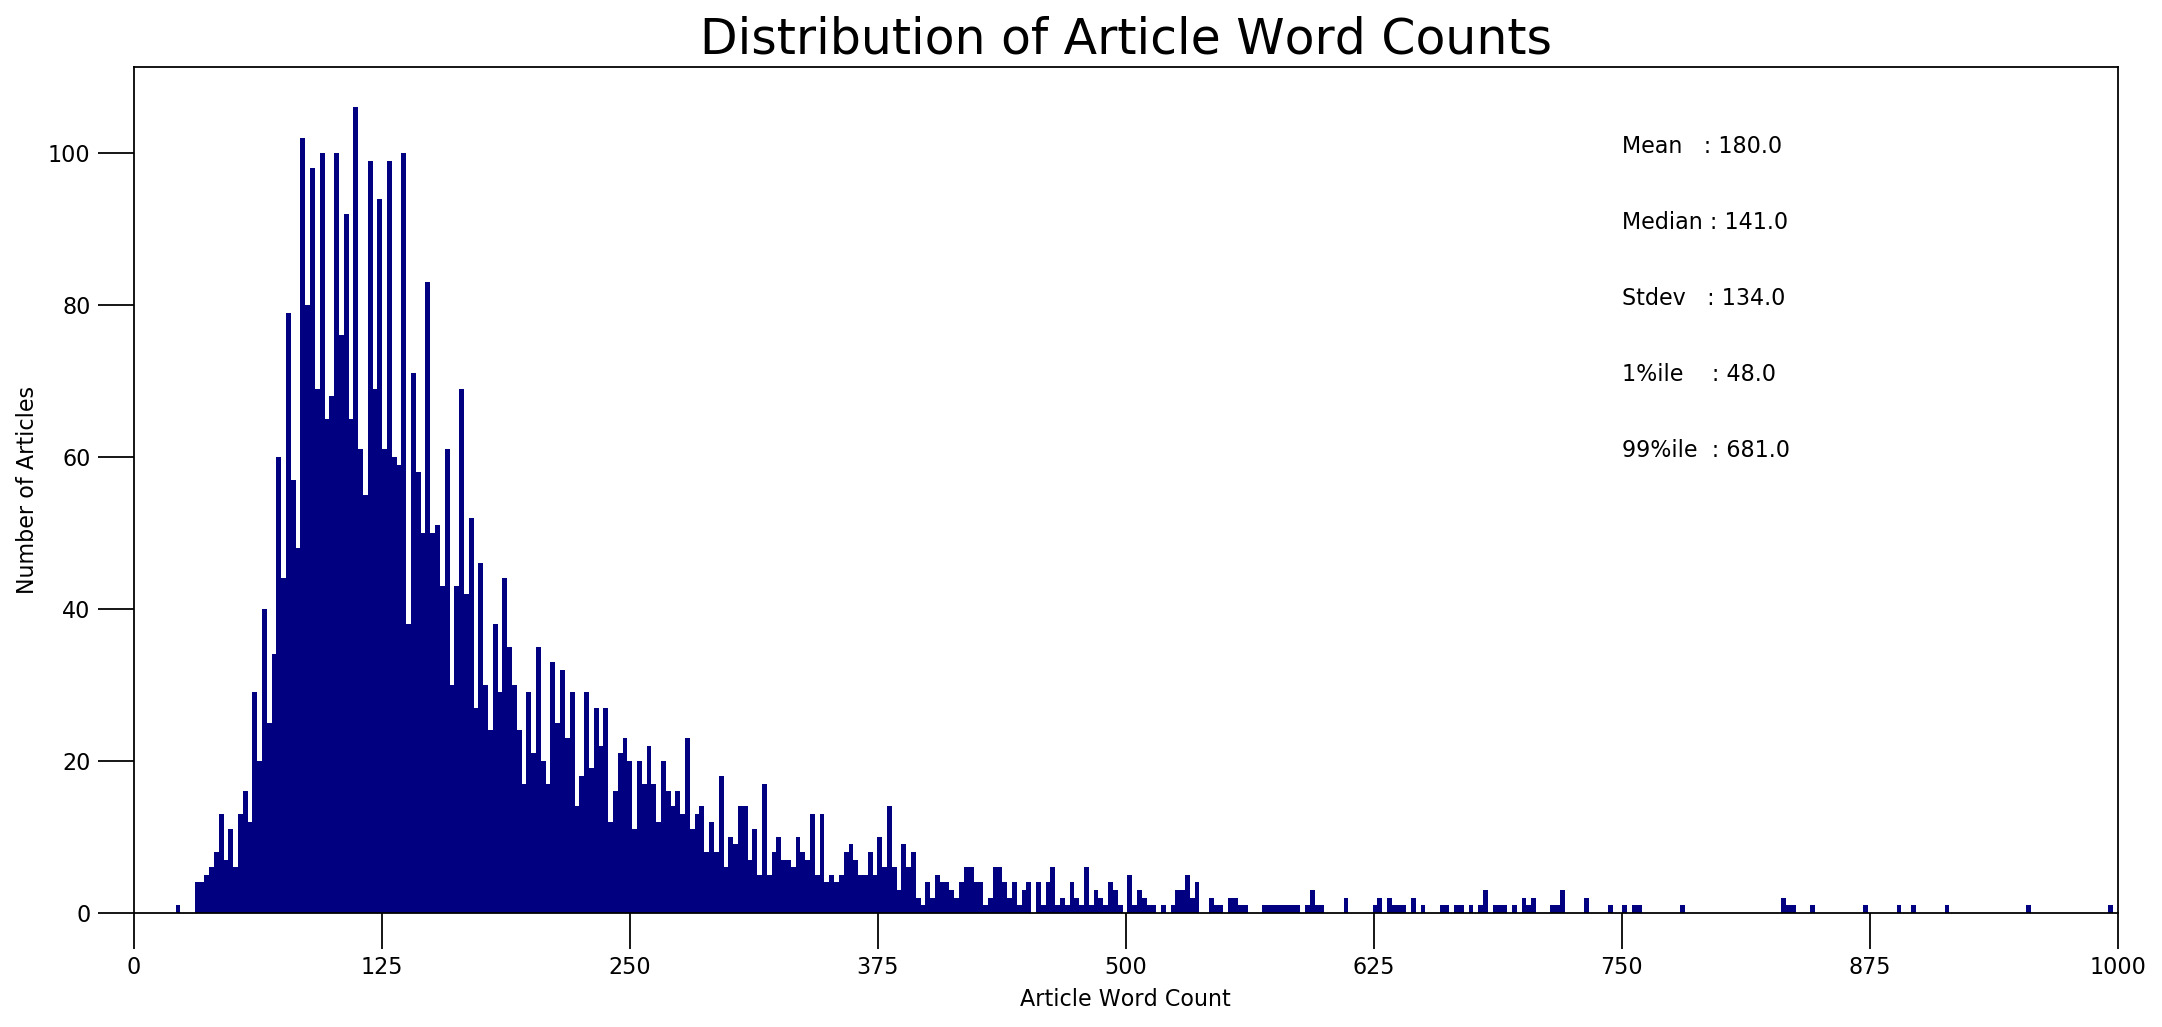

In [37]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Articles', xlabel='Article Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Article Word Counts', fontdict=dict(size=22))
plt.show()

## Distribution of word count by dominant topic

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


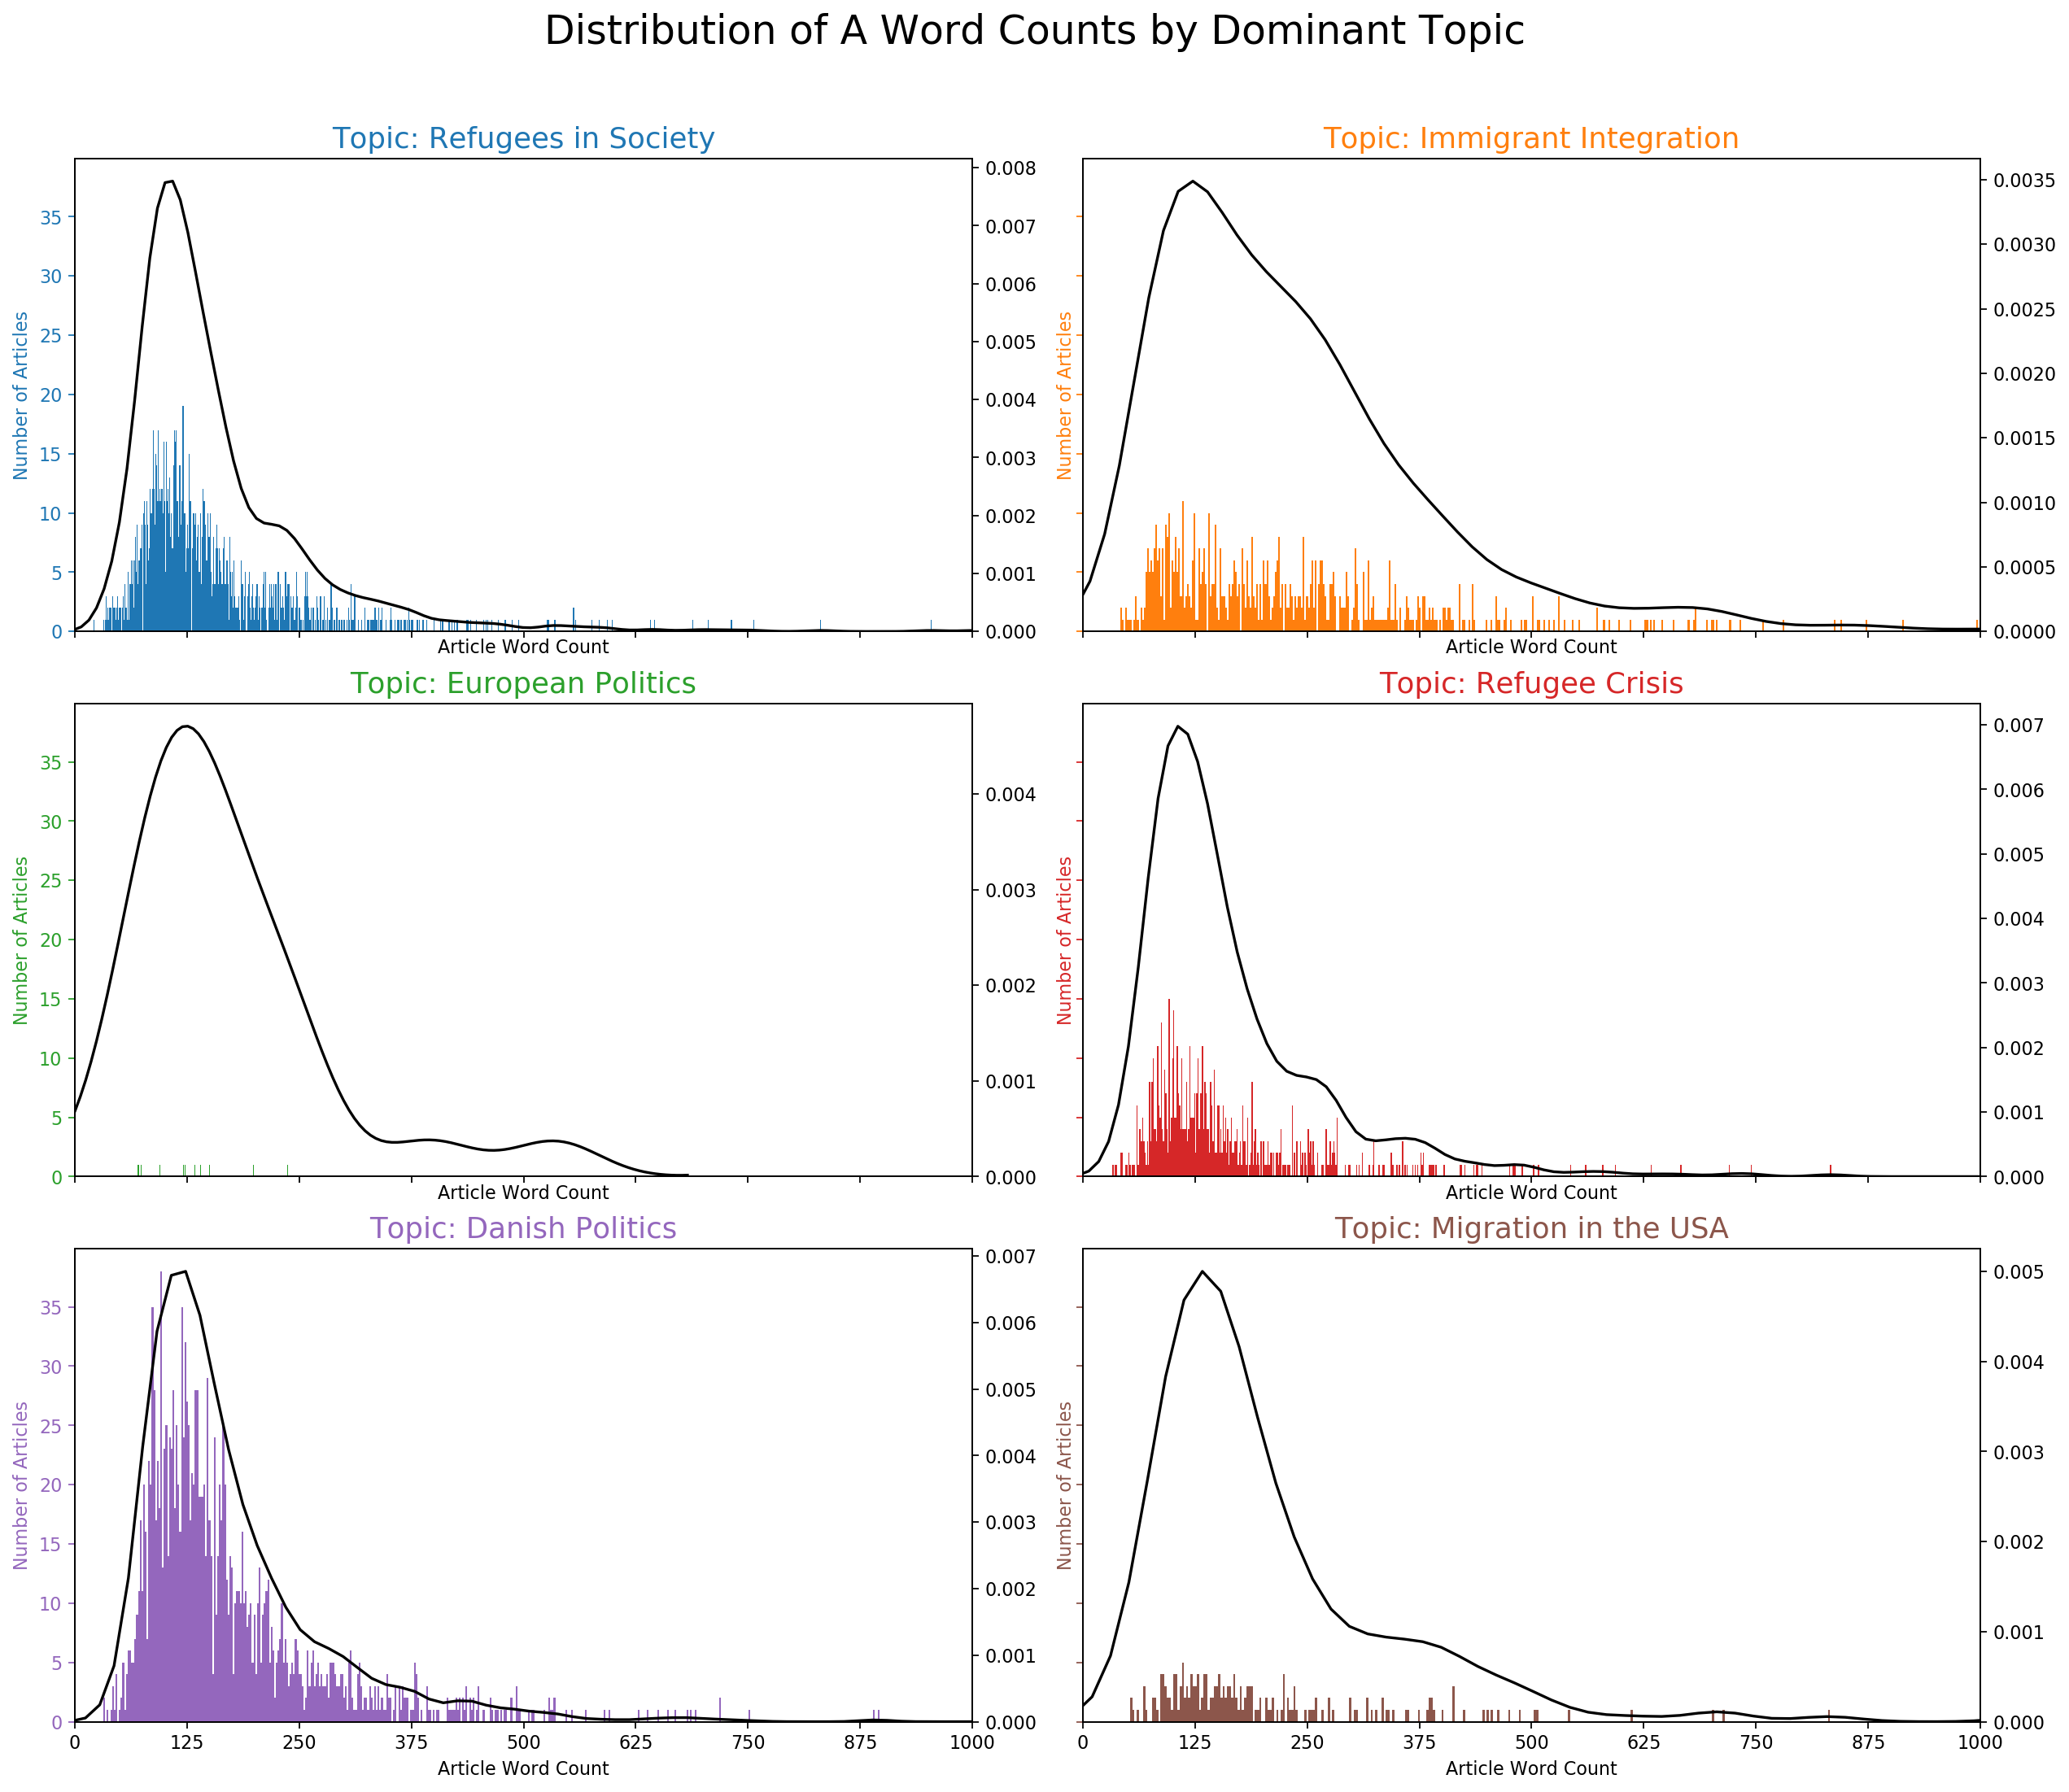

In [40]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

topic_names = ['Refugees in Society', 'Immigrant Integration', 'European Politics', 'Refugee Crisis', 'Danish Politics', 'Migration in the USA']
for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Article Word Count')
    ax.set_ylabel('Number of Articles', color=cols[i])
    ax.set_title('Topic: '+str(topic_names[i]), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of A Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Interactive vizualisation of the different topics

In the interactive graph below the topic names corresponds to the following topic numbers:
- Topic 1: Danish Politics
- Topic 2: Refugees in Society
- Topic 3: Immigrant Integration
- Topic 4: Refugee Crisis
- Topic 5: Migration in the USA
- Topic 6: European Politics

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.180176 -0.001961       1        1  32.200417
0     -0.152301 -0.052597       2        1  26.066875
1     -0.178075  0.196331       3        1  19.900265
3      0.038226 -0.142081       4        1  12.854107
5      0.156257 -0.199807       5        1   7.314377
2      0.316069  0.200115       6        1   1.663960, topic_info=      Category         Freq             Term        Total  loglift  logprob
term                                                                       
225    Default  4698.000000               eu  4698.000000  30.0000  30.0000
238    Default  4544.000000       indvandrer  4544.000000  29.0000  29.0000
89     Default  7574.000000             land  7574.000000  28.0000  28.0000
130    Default  8055.000000          danmark  8055.000000  27.0000  27.0000
226    Default  2547.000000           europa  2547.000000  26.0000  26.0000
131    Default  7245.000000            dansk  7245.000000  25.0000  25.0000
1488   Default  2476.000000            parti  2476.000000  24.0000  24.0000
349    Default  3954.000000             barn  3954.000000  23.0000  23.0000
668    Default  4401.000000         regering  4401.000000  22.0000  22.0000
228    Default  9885.000000        flygtning  9885.000000  21.0000  21.0000
61     Default  1287.000000              usa  1287.000000  20.0000  20.0000
1777   Default   792.000000         tyskland   792.000000  19.0000  19.0000
3072   Default   761.000000             tysk   761.000000  18.0000  18.0000
725    Default  1048.000000        præsident  1048.000000  17.0000  17.0000
174    Default  1887.000000           politi  1887.000000  16.0000  16.0000
1215   Default  4425.000000          kommune  4425.000000  15.0000  15.0000
278    Default  1837.000000           syrien  1837.000000  14.0000  14.0000
951    Default  1742.000000          dansker  1742.000000  13.0000  13.0000
347    Default   848.000000       amerikansk   848.000000  12.0000  12.0000
264    Default  2555.000000          procent  2555.000000  11.0000  11.0000
8948   Default   497.000000           merkel   497.000000  10.0000  10.0000
7745   Default   773.000000           trumpe   773.000000   9.0000   9.0000
634    Default  1260.000000          vestlig  1260.000000   8.0000   8.0000
2035   Default   974.000000            kæmpe   974.000000   7.0000   7.0000
1038   Default  1676.000000          venstre  1676.000000   6.0000   6.0000
1006   Default  1646.000000       folkeparti  1646.000000   5.0000   5.0000
361    Default  1992.000000          familie  1992.000000   4.0000   4.0000
3924   Default  1070.000000      efterkommer  1070.000000   3.0000   3.0000
4152   Default   640.000000            obama   640.000000   2.0000   2.0000
336    Default  1207.000000          tyrkiet  1207.000000   1.0000   1.0000
...        ...          ...              ...          ...      ...      ...
2109    Topic6   108.584297            radio   109.505470   4.0875  -4.8780
9960    Topic6    93.933708  forbundskansler    94.824486   4.0865  -5.0230
8981    Topic6    92.994217              cdu    93.882614   4.0865  -5.0330
2853    Topic6    91.795258           østrig    92.687553   4.0863  -5.0460
11819   Topic6    76.591156          reitere    77.479813   4.0844  -5.2271
1668    Topic6    72.597107           birthe    73.498764   4.0836  -5.2806
8989    Topic6    69.344597      forbundsdag    70.234367   4.0832  -5.3265
3748    Topic6    68.800667         nordmand    69.699219   4.0830  -5.3343
1684    Topic6    65.563286             rønn    66.456024   4.0824  -5.3825
1677    Topic6    57.202892         hornbech    58.095551   4.0805  -5.5189
1842    Topic6    56.071533          lolland    56.966671   4.0801  -5.5389
21884   Topic6    55.109814           haslev    56.014248   4.0797  -5.5562
3159    Topic6    56.784454        tilknytte    57.729939   4.0795  -5.5263
31000   Topic6    58.888077  